
## Elevation (DEM) vs. Flow Accumulation (ACC) ## 
In this project, we analyze topographic and hydrological data to support flood forecasting in Bhutan and its surrounding buffer zone (lat 25.0°–29.5°, lon 87.0°–93.5°).
Two key types of geospatial raster data are often used: Digital Elevation Models (DEM) and Flow Accumulation Grids (ACC).

**When to Use Flow Accumulation (ACC)**
Best for:

- Mapping water pathways
- Identifying stream networks
- Locating flood-prone zones

**Represents:**
The number of upstream cells contributing flow to a given pixel — i.e., how much water is expected to accumulate there.

**Why it's useful:**
- Directly shows where surface water is likely to concentrate
- Derived from DEM and reflects realistic hydrological flow
- Ideal for identifying rivers, valleys, and catchment areas
- Perfect for downstream flood risk modeling

👉 If goal is to model flooding, drainage paths, or river overflow zones — ACC is the more directly informative input.

**When to Use Digital Elevation Model (DEM)**
Best for:

- Understanding terrain shape
- Deriving slope, aspect, and flow direction
- Modeling rainfall-runoff or landslide potential

**Represents:**
Surface elevation (in meters above sea level) for each pixel location.

**Why it's useful:**
- The foundation for calculating hydrological features (flow direction, slope, etc.)
- Can simulate water movement before accumulation
- Helps build custom physical models for rainfall response

👉 Use DEM when you want to compute slope-based indicators, direction of flow, or custom hydrological processing.

🔄 **Best Practice: Use Both**
In ML or hybrid physical-data-driven models, combining DEM and ACC allows richer representation:
DEM provides raw topographic information
ACC embeds hydrological dynamics derived from that terrain



## 1. Crop and Save a Smaller DEM (TIF) for Bhutan + Buffer
Instead of processing the full Asia-wide DEM, we first crop and save a smaller GeoTIFF file limited to the Bhutan region and its buffer (latitude 25.0°–29.5°, longitude 87.0°–93.5°). This reduces processing time and memory usage in subsequent CSV conversion and analysis steps.

In [5]:
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import os
import gc

# Define the input and output paths
input_tif = "../../data/HydroSHEDS/as_dem_3s.tif"
output_tif = "../../data/HydroSHEDS/as_dem_Bhutan_and_buffer.tif"

# Define the bounding box for Bhutan + buffer (in degrees)
min_lon, max_lon = 87.0, 93.5
min_lat, max_lat = 25.0, 29.5

# Open the source TIFF file
with rasterio.open(input_tif) as src:
    print(f"📦 Number of bands in TIFF: {src.count}")
    if src.count != 1:
        raise ValueError("❌ Expected only one band in the DEM file.")

    # Compute the pixel window corresponding to the bounding box
    window = from_bounds(min_lon, min_lat, max_lon, max_lat, transform=src.transform)

    # Read the data within that window (band 1 = elevation)
    data = src.read(1, window=window)

    # Get the updated transform for the cropped window
    transform = src.window_transform(window)

    # Save the cropped raster to a new TIF
    out_meta = src.meta.copy()
    out_meta.update({
        "height": window.height,
        "width": window.width,
        "transform": transform
    })

    with rasterio.open(output_tif, "w", **out_meta) as out_src:
        out_src.write(data, 1)

print(f"✅ Saved: {output_tif}")
print(f"📐 Size (width x height): {window.width} x {window.height}")

# Check file size in MB
file_size_mb = os.path.getsize(output_tif) / (1024 * 1024)
print(f"💾 File size: {file_size_mb:.2f} MB")

with rasterio.open(output_tif) as tif_check:
    print(f"📌 CRS: {tif_check.crs}")
    print(f"🧭 Bounds: {tif_check.bounds}")
    print(f"📦 Data type: {tif_check.dtypes[0]}")
    print(f"🧮 NoData value: {tif_check.nodata}")

# 🔥 Clean up memory
del data, transform, out_meta, window, tif_check, src, out_src
gc.collect()
print("✅ Memory cleaned up.")

📦 Number of bands in TIFF: 1
✅ Saved: ../../data/HydroSHEDS/as_dem_Bhutan_and_buffer.tif
📐 Size (width x height): 7800.0 x 5400.0
💾 File size: 80.37 MB
📌 CRS: EPSG:4326
🧭 Bounds: BoundingBox(left=87.0, bottom=25.000000000000007, right=93.5, top=29.500000000000007)
📦 Data type: int16
🧮 NoData value: 32767.0
✅ Memory cleaned up.


## 2. Convert Cropped DEM to CSV ##
Transform the extracted Bhutan + buffer GeoTIFF into a structured CSV format. NoData values will be filtered out.

In [9]:
import rasterio
import pandas as pd
import numpy as np
import os
import gc

# Define input/output paths
tif_path = "../../data/HydroSHEDS/as_dem_Bhutan_and_buffer.tif"
csv_output = "../../data/HydroSHEDS/full_bhutan_and_buffer_dem.csv"

# Open GeoTIFF
with rasterio.open(tif_path) as src:
    print(f"📦 Number of bands in TIFF: {src.count}")
    if src.count != 1:
        raise ValueError("Expected a single-band DEM")
    
    # Read elevation data
    elevation = src.read(1)
    transform = src.transform
    nodata = src.nodata
        
    # Generate coordinate grids
    rows, cols = np.indices(elevation.shape)
    longitudes, latitudes = rasterio.transform.xy(transform, rows, cols, offset='center')
    
    # Flatten all arrays
    flat_lon = np.array(longitudes).flatten()
    flat_lat = np.array(latitudes).flatten()
    flat_elev = elevation.flatten()
    
    # Filter valid data (exclude NoData)
    valid_mask = flat_elev != nodata
    filtered_data = {
        "longitude": flat_lon[valid_mask],
        "latitude": flat_lat[valid_mask],
        "elevation": flat_elev[valid_mask]
    }

    # Create and save DataFrame
    df = pd.DataFrame(filtered_data)
    df.to_csv(csv_output, index=False)
    print(f"💾 Saved CSV: {csv_output}")
    print(f"✅ Total valid rows: {len(df):,}")

# Show file size
file_size = os.path.getsize(csv_output) / (1024 ** 2)
print(f"📏 CSV file size: {file_size:.2f} MB")

# Clean up memory
del df, elevation, flat_lat, flat_lon, flat_elev, valid_mask, filtered_data
gc.collect()
print("🧹 Memory cleaned up.")

📦 Number of bands in TIFF: 1
💾 Saved CSV: ../../data/HydroSHEDS/full_bhutan_and_buffer_dem.csv
✅ Total valid rows: 42,120,000
📏 CSV file size: 1536.65 MB
🧹 Memory cleaned up.


## 3. General Dataset Overview ##
Understand the basic structure and quality of the flow accumulation dataset. Checks for missing data, duplicates, and provides statistical information.

In [12]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("../../data/HydroSHEDS/full_bhutan_and_buffer_dem.csv")

# Always show all columns in outputs
pd.set_option("display.max_columns", None)

# Preview first 5 rows
print("📌 Preview of first 5 rows:")
display(df.head())

# Get basic info about the dataset (column names, types, non-null counts)
print("\nℹ️ DataFrame Info:")
df.info()

# Generate descriptive statistics for numeric columns
print("\n📈 Descriptive Statistics:")
display(df.describe())

# Check for missing values in each column
print("\n❓ Missing Values per Column:")
display(df.isnull().sum())

# Count the number of duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\n🔁 Number of duplicate rows: {duplicate_count}")

📌 Preview of first 5 rows:


,longitude,latitude,elevation
0,87.000417,29.499583,4985
1,87.001250,29.499583,4968
2,87.002083,29.499583,4957
3,87.002917,29.499583,4937
4,87.003750,29.499583,4916



ℹ️ DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42120000 entries, 0 to 42119999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   longitude  float64
 1   latitude   float64
 2   elevation  int64  
dtypes: float64(2), int64(1)
memory usage: 964.1 MB

📈 Descriptive Statistics:


,longitude,latitude,elevation
count,4.212000e+07,4.212000e+07,4.212000e+07
mean,9.025000e+01,2.725000e+01,2.334091e+03
std,1.876388e+00,1.299038e+00,2.111653e+03
min,8.700042e+01,2.500042e+01,-1.200000e+01
25%,8.862521e+01,2.612521e+01,8.300000e+01
50%,9.025000e+01,2.725000e+01,1.825000e+03
75%,9.187479e+01,2.837479e+01,4.538000e+03
max,9.349958e+01,2.949958e+01,8.205000e+03



❓ Missing Values per Column:


longitude    0
latitude     0
elevation    0
dtype: int64


🔁 Number of duplicate rows: 0


## 4. Distribution of Elevation Data ##
This section provides a summary and visualization of the elevation distribution across the full Bhutan territory and surrounding buffer zone based on HydroSHEDS DEM data.

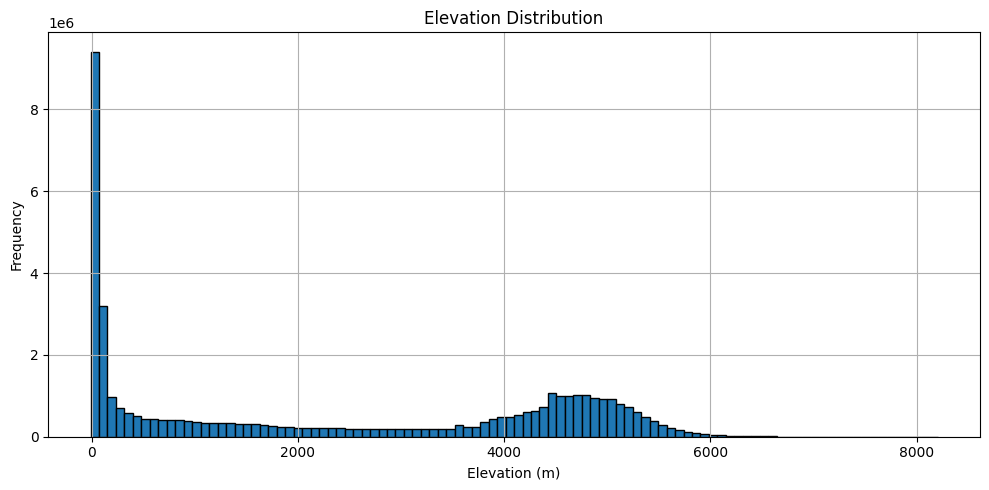

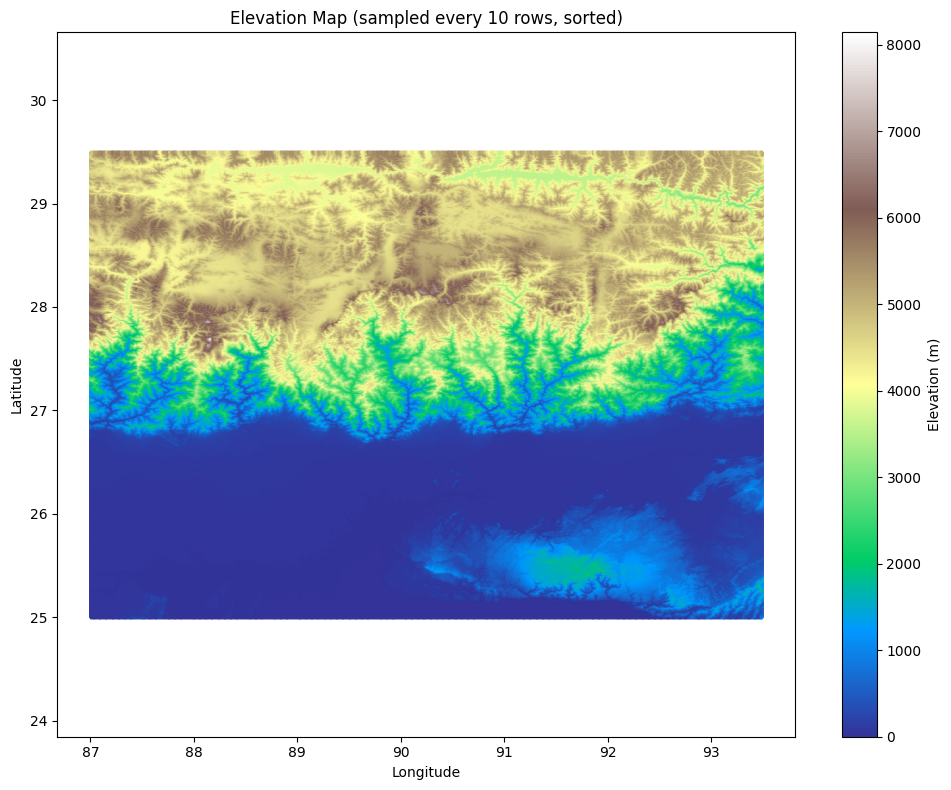

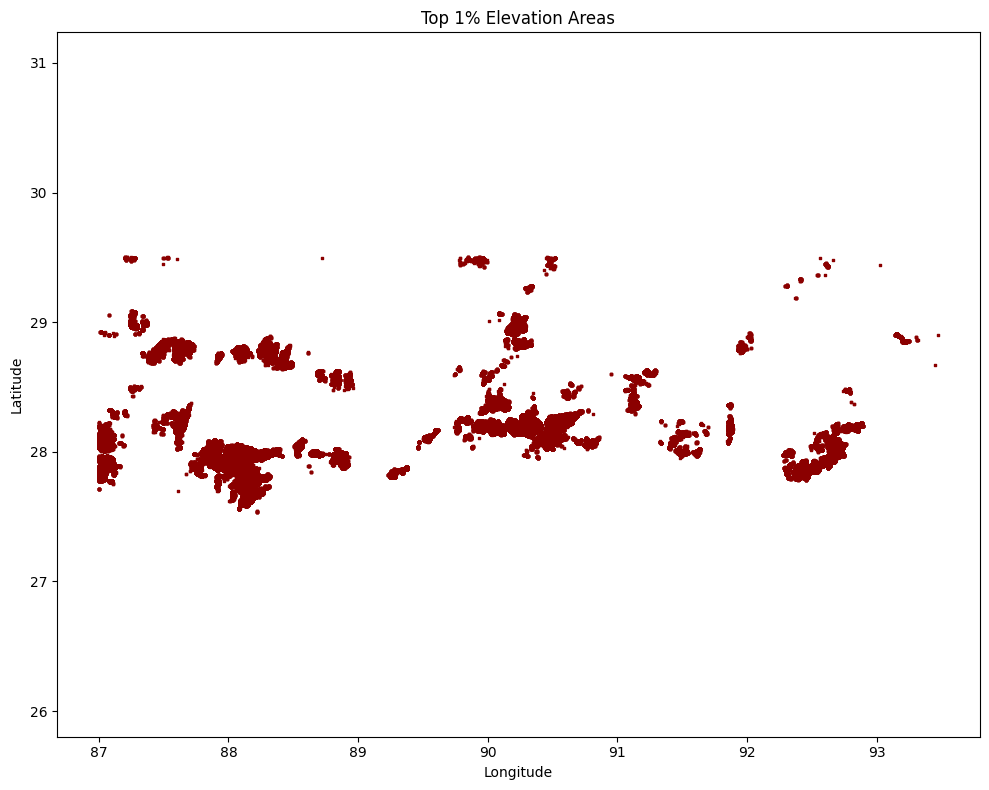

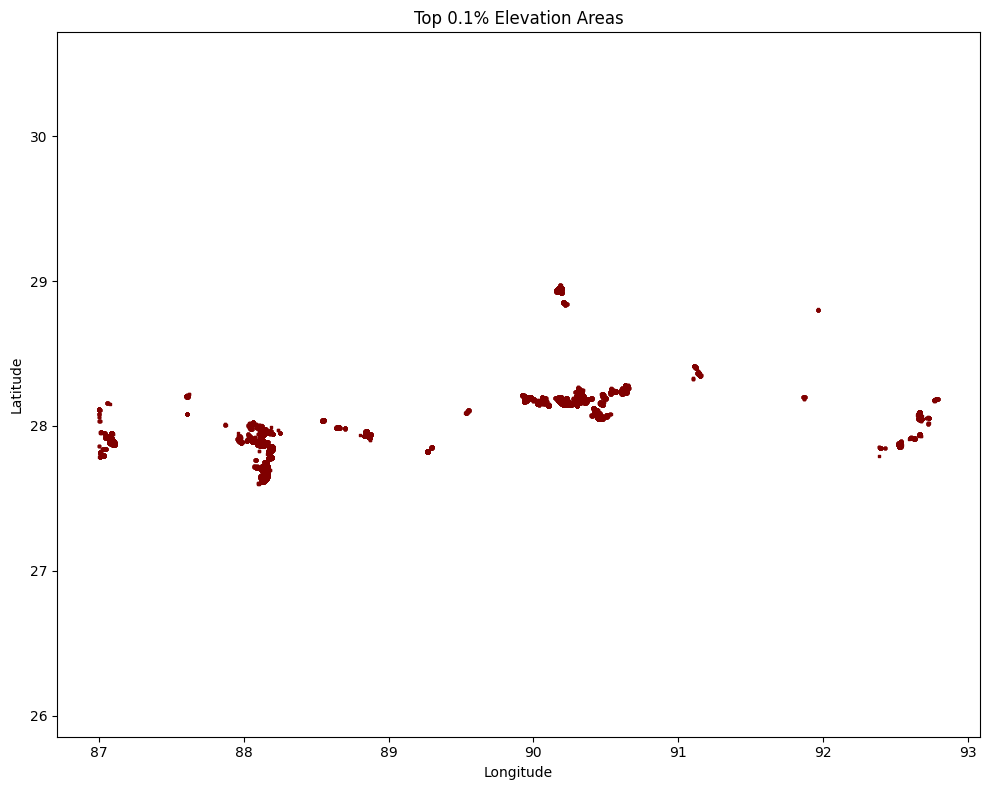

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 1. Load only necessary columns ===
df = pd.read_csv('../../data/HydroSHEDS/full_bhutan_and_buffer_dem.csv', usecols=['latitude', 'longitude', 'elevation'])

# === 2. Plot 1: Elevation Histogram ===
plt.figure(figsize=(10, 5))
plt.hist(df['elevation'], bins=100, edgecolor='black')
plt.title('Elevation Distribution')
plt.xlabel('Elevation (m)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Plot 2: Subsampled Spatial Elevation Map (improved sampling) ===
# Use stratified sampling (avoid vertical striping)
df_sorted = df.sort_values(by=['latitude', 'longitude']).reset_index(drop=True)
df_sampled = df_sorted.iloc[::10]  # adjust this number to balance quality and performance

plt.figure(figsize=(10, 8))
sc = plt.scatter(df_sampled['longitude'], df_sampled['latitude'],
                 c=df_sampled['elevation'], cmap='terrain', s=0.5, marker='s')
plt.colorbar(sc, label='Elevation (m)')
plt.title('Elevation Map (sampled every 10 rows, sorted)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.tight_layout()
plt.show()

# === 4. Plot 3: Top 1% Elevation Map ===
threshold_1 = np.percentile(df['elevation'], 99)
df_top_1 = df[df['elevation'] >= threshold_1]

plt.figure(figsize=(10, 8))
plt.scatter(df_top_1['longitude'], df_top_1['latitude'],
            c='darkred', s=1, marker='s')
plt.title('Top 1% Elevation Areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.tight_layout()
plt.show()

# === 5. Plot 4: Top 0.1% Elevation Map ===
threshold_01 = np.percentile(df['elevation'], 99.9)
df_top_01 = df[df['elevation'] >= threshold_01]

plt.figure(figsize=(10, 8))
plt.scatter(df_top_01['longitude'], df_top_01['latitude'],
            c='maroon', s=1, marker='s')
plt.title('Top 0.1% Elevation Areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 5. Bin/Quantile Segmentation ##
Classify elevation values into quantile-based categories.

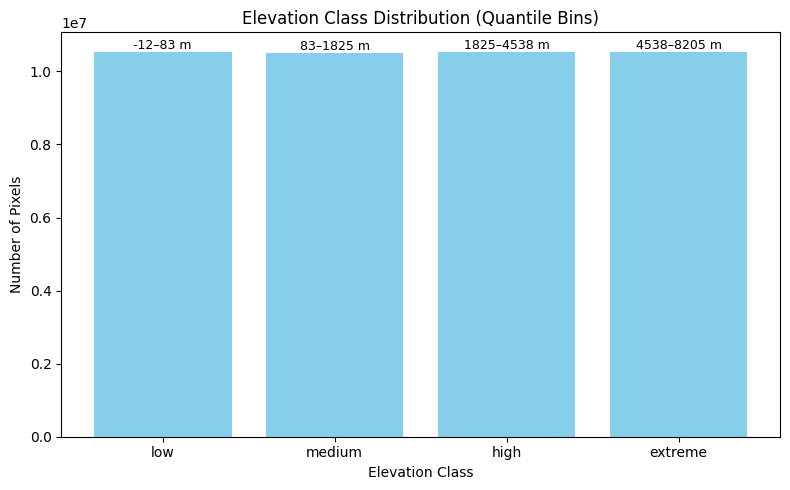

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../../data/HydroSHEDS/full_bhutan_and_buffer_dem.csv")

# Create quantile-based elevation categories
qcut_result, bins = pd.qcut(
    df["elevation"], q=4, labels=["low", "medium", "high", "extreme"], retbins=True
)
df["elevation_class"] = qcut_result

# Count values per class
counts = df["elevation_class"].value_counts().sort_index()

# Get range labels from bins
ranges = [f"{int(bins[i])}–{int(bins[i+1])} m" for i in range(len(bins)-1)]

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index.astype(str), counts.values, color="skyblue")
plt.title("Elevation Class Distribution (Quantile Bins)")
plt.xlabel("Elevation Class")
plt.ylabel("Number of Pixels")

# Add range labels above bars
for bar, label in zip(bars, ranges):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, label, ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

## 6. Geospatial Visualization ## 

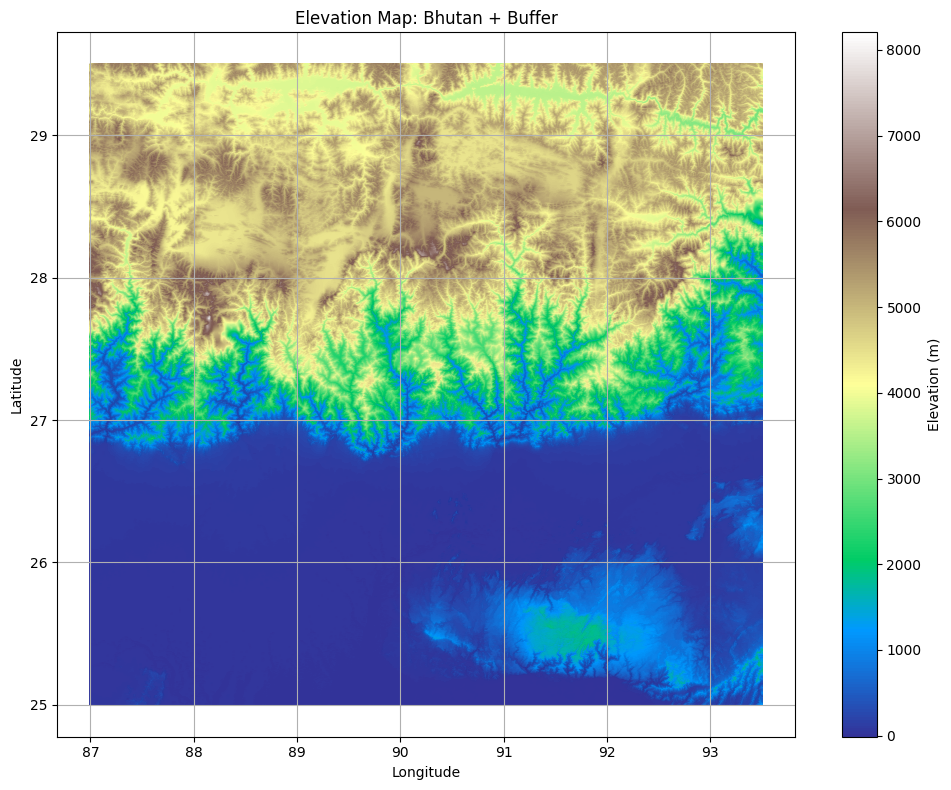

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df["longitude"], 
    df["latitude"], 
    c=df["elevation"], 
    cmap="terrain", 
    s=0.1
)

cbar = plt.colorbar(scatter)
cbar.set_label("Elevation (m)")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Elevation Map: Bhutan + Buffer")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import folium

# Define bounds
min_lat, max_lat = 25.0, 29.5
min_lon, max_lon = 87.0, 93.5
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

# Create map centered on Bhutan
m = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Add rectangle showing the Bhutan + buffer area
folium.Rectangle(
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    color="blue",
    fill=True,
    fill_opacity=0.2,
    tooltip="Bhutan + Buffer Area"
).add_to(m)

# Show map
m